# One-qubit gate fluxonium

In [46]:
import numpy as np
import sys
import qutip as qtp 
import matplotlib.pyplot as plt
from scipy import constants
import pysqkit
from pysqkit.util.linalg import get_mat_elem, tensor_prod
from pysqkit.solvers import solvkit
from typing import List
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'

My goal is to devise a test to check if unit of measures all work fine

In [47]:
# Values in GHz (divided by h)
#Fluxonium A
ec = 1.0
el = 1.5
ej = 3.8 
flux = 1/2*0 #I operate it as a transmon
n_fock = 100

In [48]:
levels = 5
flx = pysqkit.qubits.Fluxonium('A', ec, el, ej, flux, dim_hilbert=n_fock)
flx.diagonalize_basis(levels)

In [49]:
energies, eig_states = flx.eig_states(levels)
for k in range(0, 3):
    print('------')
    print('f_' + str(k) + str(k + 1) + ' = ' + str(energies[k + 1] - energies[k]) + ' GHz' )
print('------')

------
f_01 = 5.741174266101303 GHz
------
f_12 = 4.878574963617057 GHz
------
f_23 = 3.9280979318927383 GHz
------


Honestly in this configuration it seems like a good transmon with larger anharmoniciy. Something to check is in this configuration how the anharmonicity scales with $E_L$ and what could be the benefits. The anharmonicity is again approximately $E_C$.

In [50]:
for k in range(0, 2):
    print('------')
    print('|n_' + str(k) + str(k + 1) + '| = ' + \
          str(np.abs(get_mat_elem(flx.charge_op(), eig_states[k], eig_states[k + 1]))))
print('------')
print('|n_' + str(0) + str(3) + '| = '  + \
      str(np.abs(get_mat_elem(flx_a.charge_op(), eig_states[0], eig_states[3]))))

------
|n_01| = 0.5981199980725973
------
|n_12| = 0.7768481788400479
------
|n_03| = 0.050798239871481375


## Simulations

In [51]:
#simulation setup (noiseless)
freq_01 = energies[1] - energies[0]
n_01 = np.abs(get_mat_elem(flx.charge_op(), eig_states[0], eig_states[1]))
eps = 0.2
freq_drive = freq_01
rabi_freq = eps*n_01
rabi_period = 1/rabi_freq
t_points = 100000
tlist = np.linspace(0, 2*rabi_period*2*np.pi, t_points)
state_in = qtp.Qobj(inpt=eig_states[0])
rho_in = state_in*state_in.dag()
hamil0 = flx.hamiltonian(as_qobj=True)
hamil_drive = flx.charge_op(as_qobj=True) 
pulse_drive = eps*np.cos(freq_drive*tlist)

In [52]:
plot_setup = {'lw': 2.0, 'fs': 20, 'fs_text': 14, 'ls': 14}
def plot_rabi_fluxonium(
    tlist: np.ndarray, 
    prob: np.ndarray, 
    opt: dict
) -> None:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(tlist, prob, linewidth=opt['lw'], color='red')
    ax.axes.set_xlabel('$t \, [\mathrm{ns}]$', fontsize=opt['fs'])
    ax.axes.set_ylabel('$P_{in}$', fontsize=opt['fs'])
    ax.tick_params(axis='both', labelsize=opt['ls'])
    ax.set_ylim(0, 1.0)
    plt.show()

In [53]:
#simulation run A
result = solvkit.integrate(tlist, state_in, hamil0, [hamil_drive], [pulse_drive], [], "mesolve")

In [54]:
prob_in = np.zeros(t_points, dtype=float)
for k in range(0, t_points):
    prob_in[k] = qtp.expect(rho_in, result.states[k]) 

<IPython.core.display.Javascript object>


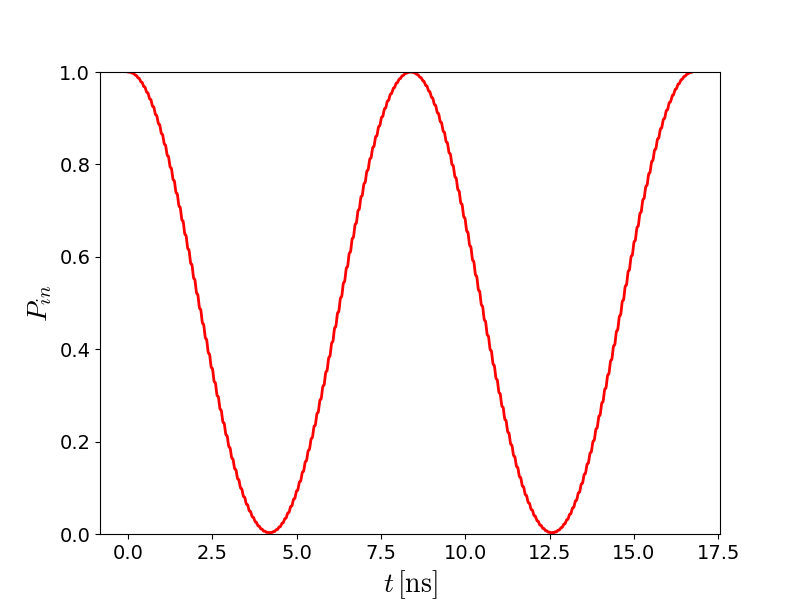

In [57]:
plot_rabi_fluxonium(tlist/(2*np.pi), prob_in, plot_setup)

In [56]:
rabi_period

8.359526543356138